Object recognition in surveillance videos with SVD

This study explore the possibility to recognise moving object, bus in the specific case, in a static surveillance video using some properties of Singular Value Decomposition. The study is divided into 3 phases:
1. Extraction of one frame for each bus passing in the street
2. Remove background from these frame to analyse better the subject
3. Classify the buses for the traveling direction


## Limu Dataset for Detection of Moving Objects 
Dataset published by R. Taniguchi from  Laboratory for Image and Media Understanding, Kuyshu University, Japan. <br>
Can be found here: https://limu.ait.kyushu-u.ac.jp/dataset/en/

In particular focus on **Bus Stop in the Morning**, it is composed by a sequence of 5000 frames, the original fps is not specified.

![Sample Image](image0600.jpg)

For semplicity all the images are converted in a single black and white channel during loading, but the all study can be extended to handle RGB images using the three channel in every operation.

If needed the dataset will be automatically downloaded in the second code cell.

### Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score, silhouette_score
import seaborn as sns
from sklearn.cluster import KMeans
import urllib.request
import zipfile

### Dataset downloading

In [2]:
# dataset 1 ( MB)

url = "https://limu.ait.kyushu-u.ac.jp/dataset/download_count/download.php?download=8"
local_file = "Bus_Stop_Morning.zip"
extracted_folder = "Bus_Stop_Morning"

# Check if the file already exists
if not os.path.exists(local_file):
    print(f"Downloading {local_file} from {url}...")
    urllib.request.urlretrieve(url, local_file)
    print(f"Downloaded {local_file}.")
else:
    print(f"{local_file} already exists.")

# Check if the extracted folder already exists
if not os.path.exists(extracted_folder):
    print(f"Extracting {local_file}...")
    with zipfile.ZipFile(local_file, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)
    print(f"Extracted to {extracted_folder}.")
else:
    print(f"{extracted_folder} already exists.")

Downloaded Bus_Stop_Morning.zip.
Extracting Bus_Stop_Morning.zip...
Extracted to Bus_Stop_Morning.


### Useful functions

In [3]:
def load_images(folder, k):
    """Loads and returns every k-th image in the specified folder as grayscale PIL Images."""
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_paths = [os.path.join(folder, f) for f in image_files]
    images = []
    for i, path in enumerate(sorted(image_paths)):
        if i % k == 0:
            img = Image.open(path).convert('L')  # Convert to grayscale
            images.append(img)
    return images

def flatten_image(img, sampling_step=1):
    """Converts a grayscale PIL Image into a 1D numpy array, sampling pixels if needed."""
    # Convert the image to a numpy array
    arr = np.array(img)
    # Sample every 'sampling_step' pixel in both dimensions
    arr = arr[::sampling_step, ::sampling_step]
    # Flatten the sampled array into a vector
    vec = arr.flatten()
    return vec

### Parameters

The next cell contains all the tunable parameters of the study. Here a breakdown:

- `image_folder = "/Users/simo/Downloads/Bus_Stop_Morning"`  
  Path to the folder containing the first set of images.

- `image_folder = "/Users/simo/Downloads/Bus_Stop_Evening"`  
  Path to the folder containing the second set of images. Uncomment it to view the results on this dataset.

- `window_size = 3`  
  Size of the sliding window used for processing the images. This determines the dimensions of the window that moves across the image.

- `pixel_sampling = 20`  
  Sampling step for pixels. For example, a value of 1 means every pixel is used, a value of 2 means every other pixel is used, and so on.

- `image_sampling = 5`  
  Sampling step for images. This means that only every 5th image in the folder will be loaded and processed.

- `theta = 0.09`  
  Threshold value for the ratio (sigma2 / sigma1). This parameter is used to determine a specific condition or criterion in the image processing algorithm.

In [12]:
# Parameters
image_folder = "Bus_Stop_Morning/Bus_Stop_Morning" 
#image_folder = "/Users/simo/Downloads/Bus_Stop_Evening" 
window_size = 3  # Sliding window size
pixel_sampling = 20  # Sampling step
image_sampling = 5
theta = 0.09  # Threshold for (sigma2 / sigma1)

np.random.seed(42)

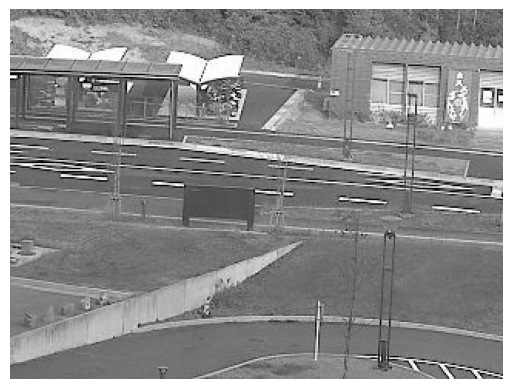

Shape of the images: (240, 320) pixel


In [13]:
# load images 
images = load_images(image_folder, image_sampling)

# first image full scale
plt.imshow(images[0], cmap='gray')
plt.axis('off')
plt.show()

img_shape = np.array(images[0]).shape

print(f"Shape of the images: {img_shape} pixel")

### Bus frame extraction 

This function processes a sequence of images using a sliding window approach, computes the Singular Value Decomposition (SVD) for each window, and checks the ratio of the second to the first singular value. It identifies local maxima in the ratio list that are above a specified threshold and return the index of these frames.

#### Steps
1. **Initialize Variables**:
   - `n`: Number of images.
   - `indxs`: List to store the middle index of each window.
   - `ratios`: List to store the computed ratios.

2. **Loop Over Each Possible Window**:
   - For each possible starting index of the window (`start_idx`), extract the window of `k` images.
   - Flatten each image in the window and stack them into a matrix `X` where each column corresponds to a flattened image.

3. **Compute SVD**:
   - Perform Singular Value Decomposition (SVD) on the matrix `X`.
   - Extract the first two singular values (`sigma1` and `sigma2`).

4. **Compute Ratio**:
   - Compute the ratio of the second to the first singular value (`sigma2 / sigma1`).
   - Append the middle index of the window and the computed ratio to `indxs` and `ratios` lists, respectively.

5. **Detect Local Maxima**:
   - Iterate through the `ratios` list to find local maxima that are also above the threshold `theta`.
   - A local maximum is identified if it is greater than its immediate neighbors and the neighbors two positions away.
   - Append the index and ratio of the local maxima to the `result` list.

6. **Return Results**:
   - Return the list of local maxima indices and their corresponding ratios, and the complete list of ratios.
  
#### Explanation

This algorithm leverages the property of singular values, which provide a good description of the entire matrix. The matrix is composed of `k` (`window_size`) frames arranged column-wise. When a bus is transiting through the frames, it causes a perturbation in the matrix, making one singular value insufficient to describe it accurately. In such cases, a significant contribution from the second singular value is needed. Moreover to make the detection phase faster the flatten image is sampled at 20:1 in both directions, resulting in a vector of 192 element from the starting 76800.

The frames returned by the function are the local maxima of the ratios. By identifying these local maxima, the algorithm returns the frames with the most significant changes, indicating that a bus is approximately in the middle of the image.

The identified frames are eventually plotted.

Detected 27 different bus images


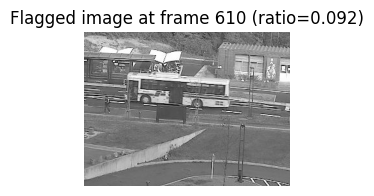

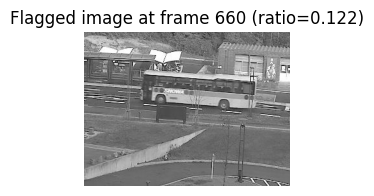

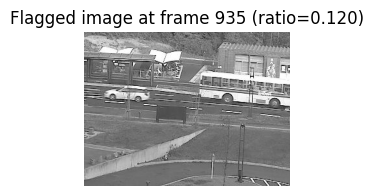

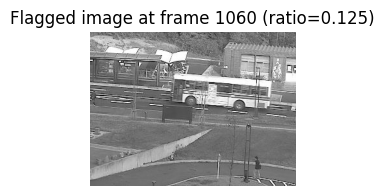

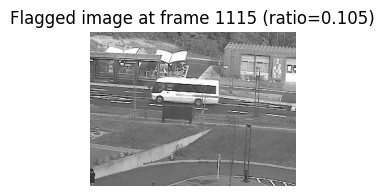

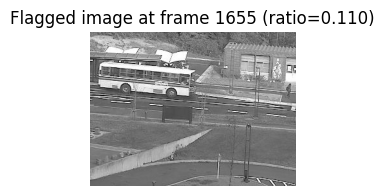

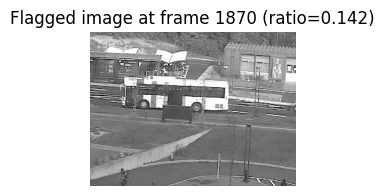

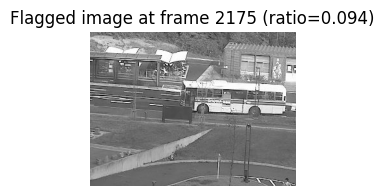

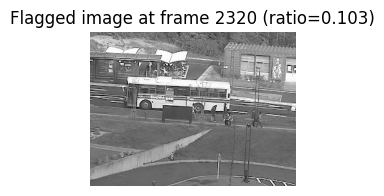

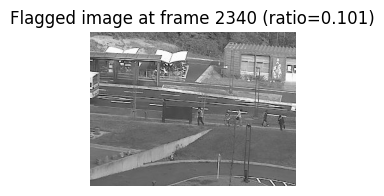

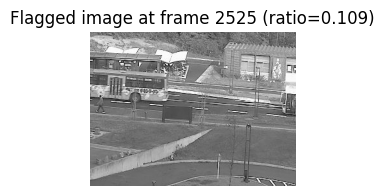

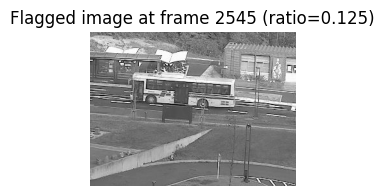

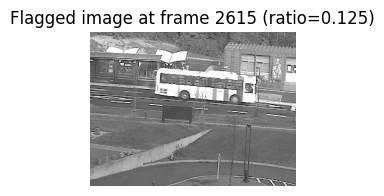

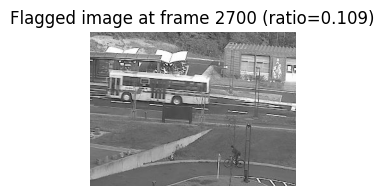

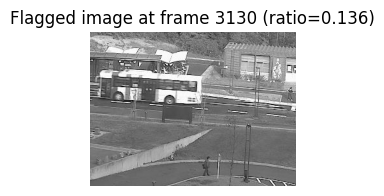

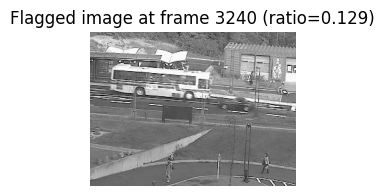

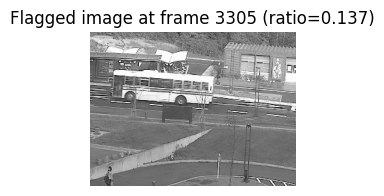

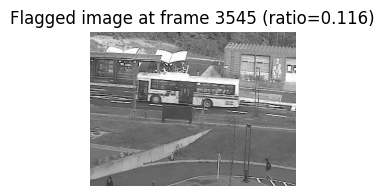

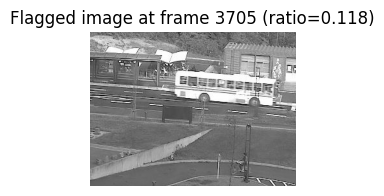

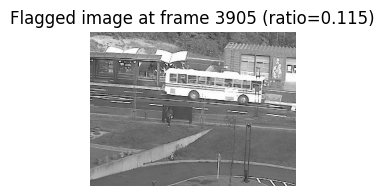

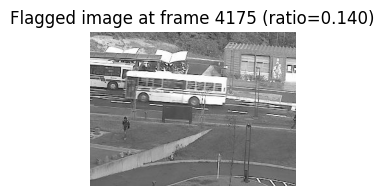

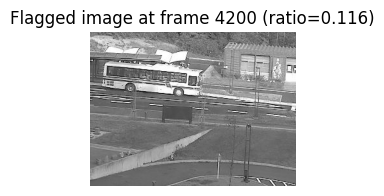

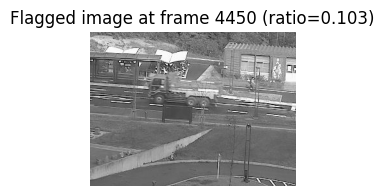

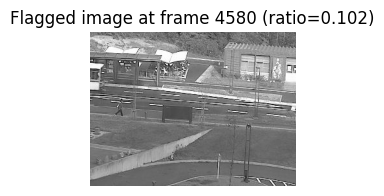

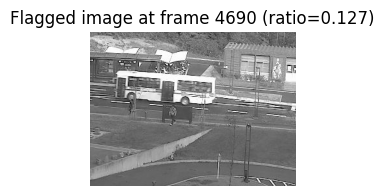

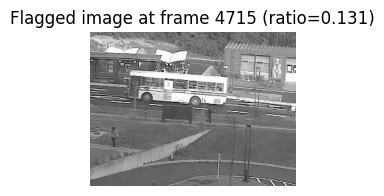

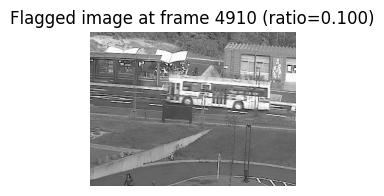

In [14]:
def process_images(images, k, pixel_sampling, theta):
    """Processes the images in a sliding window, computes random SVD, and checks the ratio."""
    n = len(images)
    indxs = []
    ratios=[]
    left_singular = []

    # Loop over each possible window
    for start_idx in range(n - k + 1):
        window_imgs = images[start_idx:start_idx + k]

        # Flatten each image in the window and stack into a matrix
        flattened_cols = [flatten_image(img, pixel_sampling) for img in window_imgs]
        X = np.column_stack(flattened_cols)  # shape: (num_pixels, k)

        # Compute SVD
        U, Sigma, Vt = np.linalg.svd(X)
        sigma1, sigma2 = Sigma[0], Sigma[1]
        
        # Compute ratio of second to first singular value
        ratio = sigma2 / sigma1 if sigma1 != 0 else 0
        
        indxs.append(start_idx + (k//2))
        ratios.append(ratio)
        left_singular.append(U[:, 0])
            
    # detect local maxima in the ratio list
    # We'll check that the local max is also above `theta`
    result = []
    left_singular_vec = []
    for i in range(2, len(indxs) - 2):
        current_ratio = ratios[i]
        prev_ratio = ratios[i-1]
        next_ratio = ratios[i+1]
        prev_ratio_2 = ratios[i-2]
        next_ratio_2 = ratios[i+2]
        
        if current_ratio > prev_ratio and current_ratio > next_ratio \
            and current_ratio > prev_ratio_2 and current_ratio > next_ratio_2 \
            and current_ratio > theta:
            # i is a local maximum index in the result list
            result.append((indxs[i], ratios[i]))
            left_singular_vec.append(left_singular[i])

    return result, ratios, left_singular_vec

detections, ratios, left_singular_vec = process_images(images, window_size, pixel_sampling, theta)

print(f"Detected {len(detections)} different bus images")

# display flagged images
for idx, r in detections:
    plt.figure(figsize=(3, 2))
    plt.imshow(images[idx], cmap='gray')
    plt.title(f"Flagged image at frame {idx*image_sampling} (ratio={r:.3f})")
    plt.axis('off')
    plt.show()

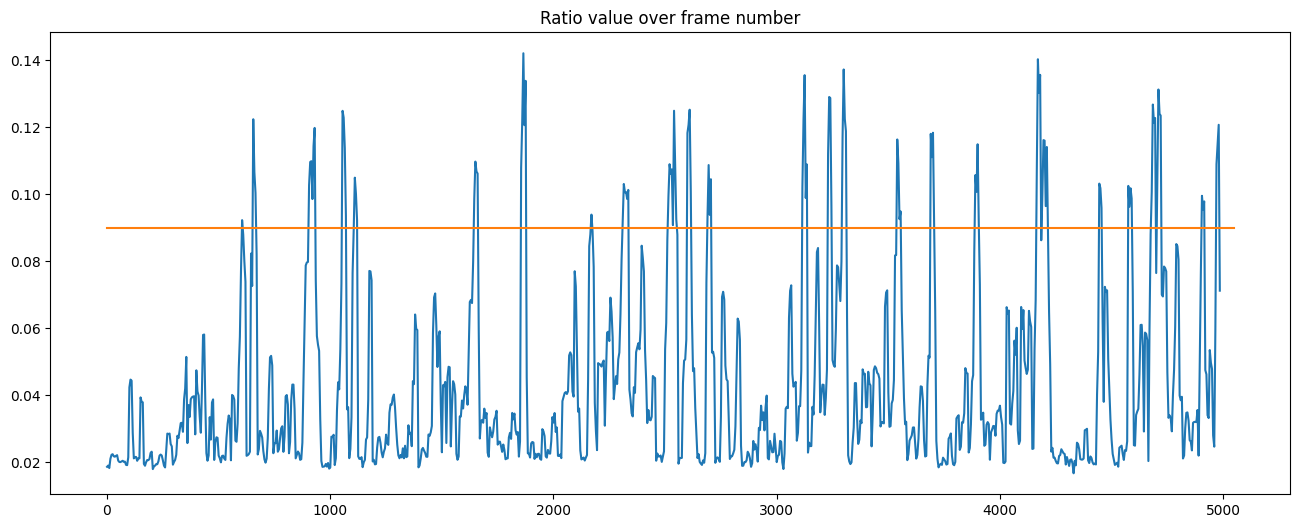

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(np.arange(1, len(ratios)*image_sampling, image_sampling), ratios)
plt.plot([0, len(images)*image_sampling+50], [theta, theta])
plt.title("Ratio value over frame number")
plt.show()

#### Ratio plot

The plot above represent the ratio of the second to the first singular value in the all the sliding windows. Can be notice as there are many peaks that represent a big change (movement) in the windows that execed the threshold, a bus in our case. If interested in, for example, counting every vehicle would be enough changinh the value of the threshold to a lower value.

### Clustering Buses by Direction

This section outlines the process of clustering buses based on their direction using **KMeans clustering**. The clustering performance is evaluated using the **F1 score**, a **confusion matrix**, and the **silhouette score**.

#### Methodology
1. **Data Representation:**
   - The clustering is performed on the **left singular vectors** obtained from the Singular Value Decomposition (SVD) of sliding windows where a bus is detected.
   - Specifically, the **first column of the matrix \( U \)** is used as the feature vector for clustering. This approach removes dependency on the **time variable** (i.e., the length of the sliding window).

2. **Clustering Algorithm:**
   - **KMeans clustering** is applied to group buses into clusters based on their direction.
   - The number of clusters is determined by the problem context (e.g., distinguishing between two primary directions).

3. **Performance Evaluation:**
   - The **F1 score** and **confusion matrix** are used to assess the accuracy of the clustering results.
   - Additionally, the **silhouette score** is computed to evaluate the separation and cohesion of the clusters.

#### Results
- **Morning Dataset:**
  - The clustering achieves **high accuracy**, with only **2 misclassified cases** out of **27** total cases.
- **Evening Dataset:**
  - The clustering achieves **100% accuracy**, indicating perfect classification.
- **Silhouette Score:**
  - The silhouette score is **0.14**, suggesting that the clusters are **not well-separated**. This indicates potential overlap or ambiguity in the clustering results, despite the high accuracy.

#### Conclusion
The use of the **first column of \( U \)** effectively captures the directional information of buses, making the clustering process independent of the sliding window length. This approach demonstrates the effectiveness of using SVD and KMeans clustering for classifying bus directions. However, the low silhouette score suggests that additional features or alternative clustering methods may be necessary to achieve better-defined clusters.

F1 Score:0.93
Silhouette score: 0.14


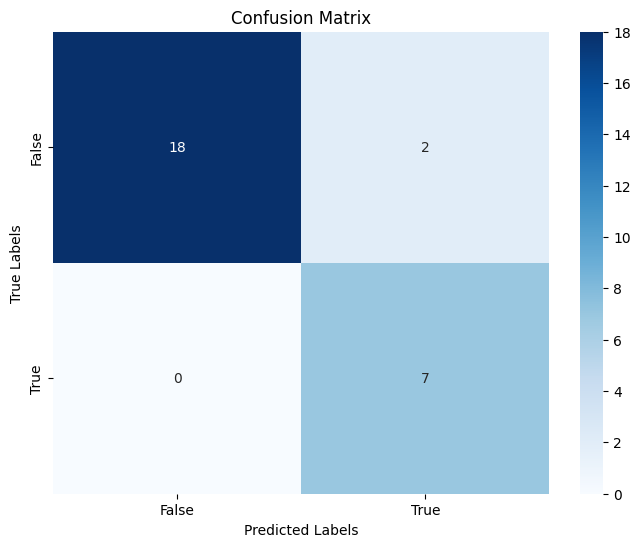

In [16]:
if "Morning" in image_folder:
    true_labels = [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]
elif "Evening" in image_folder:
    true_labels = [1, 1, 1, 1, 0, 1, 0, 0]
else:
    print(f"Missing true label for folder: {image_folder}")

# Convert the list of right singular vectors to a numpy array
left_sing_vec_array = np.array(left_singular_vec)

# Apply KMeans clustering
num_clusters = 2  # classify buses into 2 directions
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(left_sing_vec_array)

# Get the cluster labels
labels = kmeans.labels_

f1 = f1_score(true_labels, labels, average='weighted')

#swap labels if necessary
if f1 < 0.5:
    true_labels = [not x for x in true_labels]
    f1 = f1_score(true_labels, labels, average='weighted')

print(f"F1 Score:{f1:.2f}")

sil = silhouette_score(left_sing_vec_array, true_labels)

print(f"Silhouette score: {sil:.2f}")

# Compute the confusion matrix
cm = confusion_matrix(true_labels, labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Background Separation Using SVD

This code demonstrates how to use Singular Value Decomposition (SVD) to separate the background from the foreground in a sequence of images. The process involves flattening the images, computing the SVD, and constructing a rank-1 background approximation.

#### **Why SVD Works for Background Separation**
In the context of background separation:
- The **background** in an image or video is typically the most dominant and consistent part of the scene.
- The **foreground** (e.g., moving objects, people) is usually smaller in magnitude and less consistent.

SVD naturally separates the data into components based on their significance:
- The **first few singular values** (and their corresponding singular vectors) capture the most dominant patterns, which often correspond to the **background**.
- The **remaining singular values** capture smaller, less significant patterns, which often correspond to the **foreground** or noise.
  
- The **background** is typically low-rank (i.e., it can be represented by a small number of singular values) because it is consistent across frames or images.
- The **foreground** is sparse and high-rank (i.e., it requires many singular values to represent) because it consists of smaller, varying elements.
- By truncating the SVD to keep only the top \( k \) singular values, we effectively separate the low-rank background from the sparse foreground.


#### **Advantages of SVD for Background Separation**
- **No Prior Assumptions:** It does not require prior knowledge of the background or foreground.
- **Flexible:** It can be applied to images, videos, or any data represented as a matrix.


#### **Limitations**
- **Computational Cost:** For very large datasets, SVD can be computationally expensive.
- **Sensitivity to Noise:** Noise in the data can affect the quality of the separation.
- **Assumption of Low-Rank Background:** If the background is not low-rank (e.g., dynamic backgrounds), SVD may not perform well.


#### Steps

1. **Flatten 30 images and stack them into a matrix `X`**:
   - If there are fewer than 30 images, it will use all available images.
   - The selected images are the one that obtained the lowest ratio in the detection phase, this ensure to use the images with the less movement.
   - `X` is a matrix where each column is a flattened image.

2. **Compute the SVD of `X`**:
   - `U`, `S`, `Vt` are the matrices resulting from the SVD.

3. **Construct a rank-1 background approximation**:
   - This approximation is constructed using the first singular value and vectors.

4. **Subtract the background from the original image to isolate the foreground**:
   - The foreground is the difference between the original image and the background.


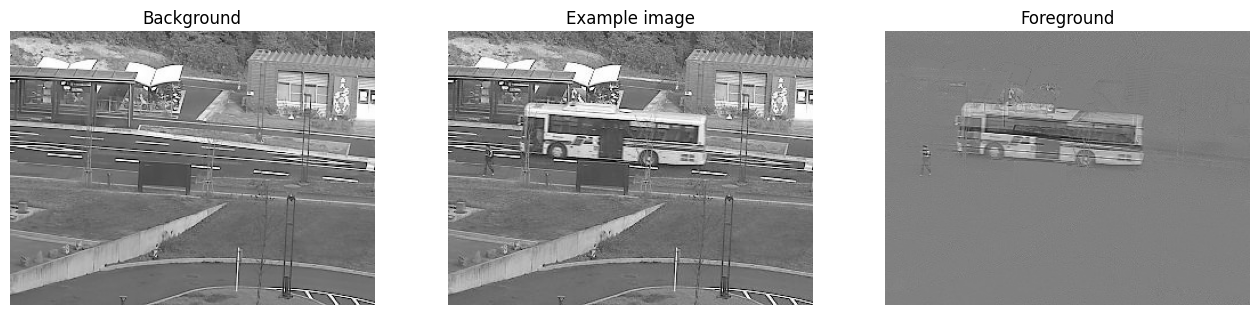

In [17]:
# 1. Flatten 30 images and stack them into a matrix X (columns are flattened images)
num_images_to_use = min(30, len(images))
max_ratio_images = sorted(ratios)[num_images_to_use]
images_to_use = [indx for indx in range(len(images)-4) if ratios[indx]<=max_ratio_images]
X = np.column_stack([flatten_image(images[i]) for i in images_to_use])

# 2. Compute the full SVD of X
U, S, Vt = np.linalg.svd(X, full_matrices=False)

# 3. Construct a rank-1 background approximation
rank1_background = np.outer(U[:, 0], Vt[0, :]) * S[0]

# 4. Reshape the background back to the original shape
rank1_background = np.mean(rank1_background, axis=1)
image_shape = np.array(images[0]).shape
background = rank1_background.reshape(image_shape)

# Select as an example the first bus detected
example_index = detections[0][0]
example_image = np.array(images[example_index])
example_foreground = example_image - background

# Display the original image, the rank-1 background, and the foreground
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(background, cmap='gray')
axs[0].set_title("Background")
axs[0].axis('off')

axs[1].imshow(example_image, cmap='gray')
axs[1].set_title("Example image")
axs[1].axis('off')

axs[2].imshow(example_foreground, cmap='gray')
axs[2].set_title("Foreground")
axs[2].axis('off')

plt.show()

The background removal process effectively separates the **background** from the **foreground** (e.g., buses) in the provided example image. While the results are not perfect, the background is well-detected, and the bus (foreground) is clearly separated. This separation lays the groundwork for further processing steps in the pipeline, such as detecting different types of buses or bus lines.
Implementing this process on RGB images could enhance its performance and utility in real-world applications.


Below further examples

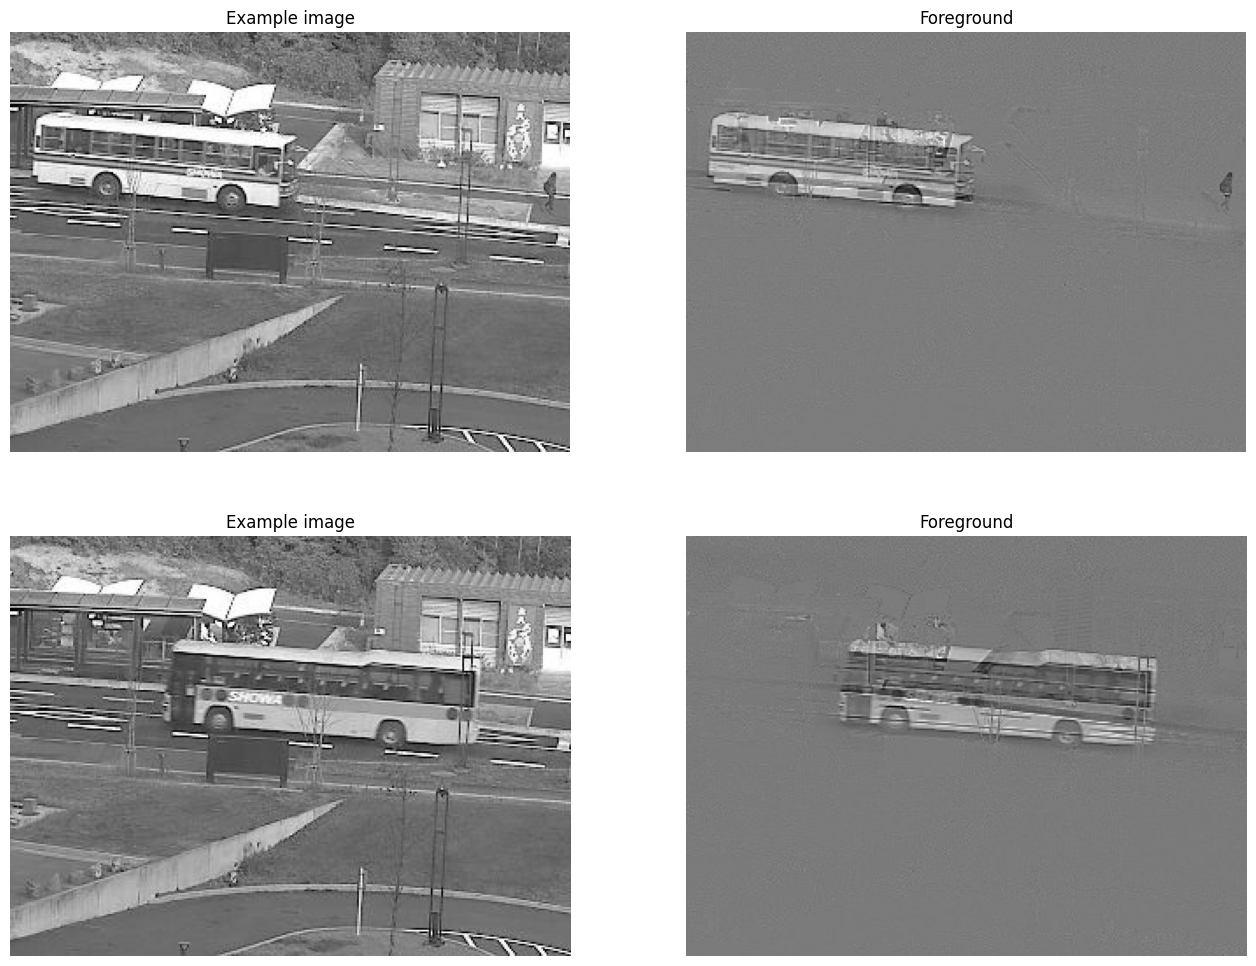

In [18]:
example_index = detections[5][0]
example_image = np.array(images[example_index])
example_foreground = example_image - background

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

axs[0, 0].imshow(example_image, cmap='gray')
axs[0, 0].set_title("Example image")
axs[0, 0].axis('off')

axs[0, 1].imshow(example_foreground, cmap='gray')
axs[0, 1].set_title("Foreground")
axs[0, 1].axis('off')


example_index = detections[1][0]
example_image = np.array(images[example_index])
example_foreground = example_image - background

axs[1, 0].imshow(example_image, cmap='gray')
axs[1, 0].set_title("Example image")
axs[1, 0].axis('off')

axs[1, 1].imshow(example_foreground, cmap='gray')
axs[1, 1].set_title("Foreground")
axs[1, 1].axis('off')

plt.show()